# Previsão de renda

### 4 elementos importantes para um projeto de sucesso
- Esse notebook
- Streamlit com as análises
- Seu Github com o projeto
- Vídeo no readme do github mostrando o streamlit

## Etapa 1 CRISP - DM: Entendimento do negócio

<span style="color:grey">A base de dados 'Previsão de renda' tem como objetivo estimar a renda de indivíduos com base em características como idade, escolaridade, ocupação, estado civil, entre outras variáveis, geralmente esse tipo de analise é feita por bancos ou instituições financeiras para analise de crédito.</span>


## Etapa 2 CRISP-DM: Entendimento dos dados¶
Segue uma descrição das colunas desse dataset:

### Dicionário de dados

| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data da coleta dos dados                                      | Object       |
| id_cliente              |  Numero de identificação                                      | Int          |
| sexo                    |  Sexo do cliente                                      | Object       |
| posse_de_veiculo        |  Se o cliente possui veiculo                                      | Bool         |
| posse_de_imovel         |  Seoclientepossui imovel                                    | Bool         |
| qtd_filhos              |  Numero de filhos                                      | Int          |
| tipo_renda              |  Tipo de renda do cliente                                      | Object       |
| educacao                |  Tipo de escolaridade do cliente                                      |Object|
| estado_civil            |  Tipo de relacionamento do cliente          | Object       |
| tipo_residencia         |  Tipo de residencia do cliente                                      | Object       |
| idade                   |  Idade do cliente                                      | Int          |
| tempo_emprego           |  Tempo empregado do cliente                                      | Float        |
| qt_pessoas_residencia   |  Quantidade de pessoas na residencia do cliente                                      | Float        |
| renda                   |  Valor da renda do cliente                                      | Float        |


### Carregando os pacotes
É considerado uma boa prática carregar os pacotes que serão utilizados como a primeira coisa do programa.

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import joblib

from ydata_profiling import ProfileReport

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from patsy import dmatrices

%matplotlib inline

In [9]:
renda = pd.read_csv('./input/previsao_de_renda.csv')

In [10]:
renda.head()

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis. 

In [12]:
prof = ProfileReport(renda, explorative=True, minimal=True)
prof


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
prof.to_file('./output/renda_analisys.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
renda.describe()

,Unnamed: 0,id_cliente,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,15000.000000,15000.000000,15000.000000,15000.000000,12427.000000,15000.000000,15000.000000
mean,7499.500000,8304.871400,0.432333,43.882333,7.722635,2.206400,5697.287057
std,4330.271354,4797.780446,0.746631,11.273155,6.711189,0.909792,8266.816289
min,0.000000,1.000000,0.000000,22.000000,0.117808,1.000000,118.710000
25%,3749.750000,4181.000000,0.000000,34.000000,2.973973,2.000000,2026.110000
50%,7499.500000,8297.000000,0.000000,43.000000,6.013699,2.000000,3499.720000
75%,11249.250000,12403.000000,1.000000,53.000000,10.120548,3.000000,6392.167500
max,14999.000000,16649.000000,14.000000,68.000000,42.906849,15.000000,245141.670000


<span style="color:grey">Na analise univariada foi percebido que algumas variaveis como 'UNNAMED: 0', 'ID_CLIENTE' não são relevantes para a analise de renda pois não tem nenhuma correlação, alem disso foi visto que 'QTD_FILHOS' tem 70% das linhas zeradas e 'TEMPO_EMPREGO' tem 16% de dados faltantes.</span>


### Entendimento dos dados - Bivariadas




Vou converter os dados do tipo str, bool e object em inteiros para fazer uma matriz de correlação.

In [18]:
renda['sexo'] = renda['sexo'].map({'M':0, 'F':1})
renda['posse_de_veiculo'] = renda['posse_de_veiculo'].astype(int)
renda['posse_de_imovel'] = renda['posse_de_imovel'].astype(int)
renda_dummie = pd.get_dummies(renda, columns = ['tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'], dtype=int)
renda_dummie.drop(['data_ref', 'Unnamed: 0', 'id_cliente'], axis=1, inplace=True)
renda_dummie.rename(columns={'tipo_renda_Servidor público': 'tipo_renda_Servidor_publico'}, inplace=True)

In [19]:
renda_dummie.head(5)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,tipo_renda_Assalariado,tipo_renda_Bolsista,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,1,0,1,0,26,6.602740,1.0,8060.34,0,0,...,0,1,0,0,0,1,0,0,0,0
1,0,1,1,0,28,7.183562,2.0,1852.15,1,0,...,0,0,0,0,0,1,0,0,0,0
2,1,1,1,0,35,0.838356,2.0,2253.89,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,1,1,30,4.846575,3.0,6600.77,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,33,4.293151,1.0,6475.97,1,0,...,0,1,0,0,0,0,0,0,0,1


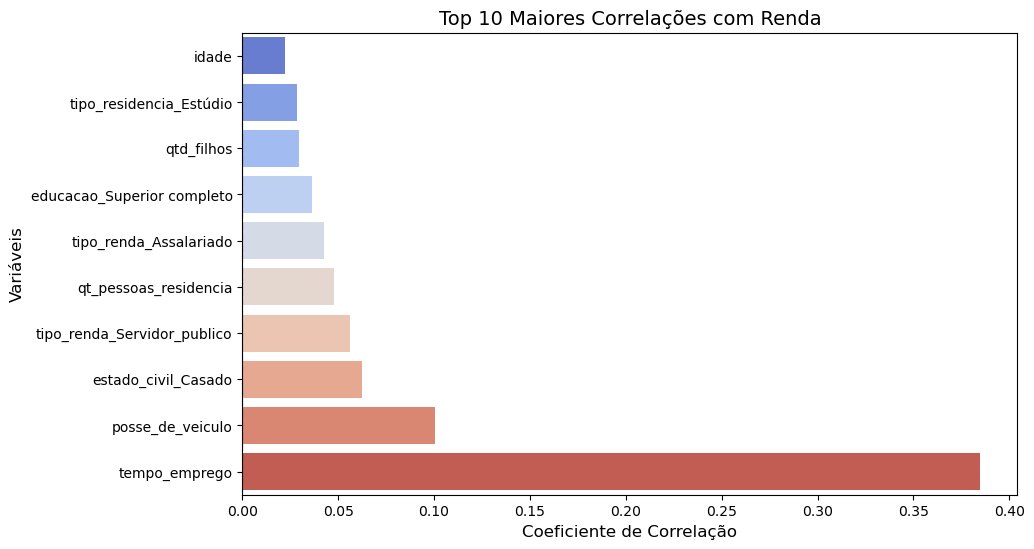

In [20]:
# Calcular a correlação da variável 'renda' com todas as outras
correlacoes_renda = renda_dummie.corr()['renda'].drop('renda').sort_values()

# Gráfico de barras para as 10 maiores correlações
bottom_correlations = correlacoes_renda.tail(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=bottom_correlations.values, y=bottom_correlations.index, palette='coolwarm', hue=bottom_correlations.index)

plt.title("Top 10 Maiores Correlações com Renda", fontsize=14)
plt.xlabel("Coeficiente de Correlação", fontsize=12)
plt.ylabel("Variáveis", fontsize=12)
plt.axvline(x=0, color='black', linestyle="--")  # Linha no zero para referência
plt.legend([],[], frameon=False)  # Remover a legenda
plt.show()


<span style="color:grey">Podemos ver que 'TEMPO_EMPREGO' e 'POSSE_DE_VEICULO', são as variaveis mais correlaciondas de acordo com essa tecinica de matriz, sendo o mais proximo de 1 bom.</span>


## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



In [23]:
# Ajustando outliners da coluna 'RENDA'
renda_dummie['renda'] = renda_dummie['renda'].replace({
    118.71: 1180.71,
    211.04: 2110.04,
    222.87: 2220.87,
    238.20: 2380.20,
    249.14: 2490.14
})

# Tratando dados NA
print(renda_dummie.isnull().sum()[renda_dummie.isnull().sum() > 0])
renda_dummie = renda_dummie.dropna()

tempo_emprego    2573
dtype: int64


## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


<span style="color:grey">Usarei o modelo supervisionado de regressão, visto que temos dados categoricos e possuimos uma variavel resposta.</span>


### Rodando o modelo


In [27]:
renda['renda'].max()

245141.67

In [28]:
# separndo variavel resposta (y) das explicativas (X)
y = renda_dummie['renda']
X = renda_dummie[['tempo_emprego', 'posse_de_veiculo', 'estado_civil_Casado', 'qt_pessoas_residencia', 'tipo_renda_Assalariado', 'tipo_renda_Servidor_publico', 'idade', 'sexo', 'posse_de_imovel']]
#X = renda_dummie.drop(columns=['renda'])

# separando as vaariaveis teste e treionamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Escolhendo o modelo (DecicionTerrRegressor)
regressor = DecisionTreeRegressor(random_state=100)

# Treinando o modelo
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=100)

## Etapa 5 Crisp-DM: Avaliação dos resultados


In [30]:
# Fazendo previsões em X_test
y_pred = regressor.predict(X_test)

# Calculando o RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE é a raiz do MSE
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}")

# Calculando o MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Erro absoluto médio (MAE): {mae:.2f}")

# Calculando o MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Erro Quadrático Médio (MSE): {mse:.2f}")

# Calculando o R²
r2 = r2_score(y_test, y_pred)
print(f"Coeficiente de Determinação (R²): {r2:.2f}")


Raiz do Erro Quadrático Médio (RMSE): 7415.78
Erro absoluto médio (MAE): 3222.01
Erro Quadrático Médio (MSE): 54993783.18
Coeficiente de Determinação (R²): 0.14


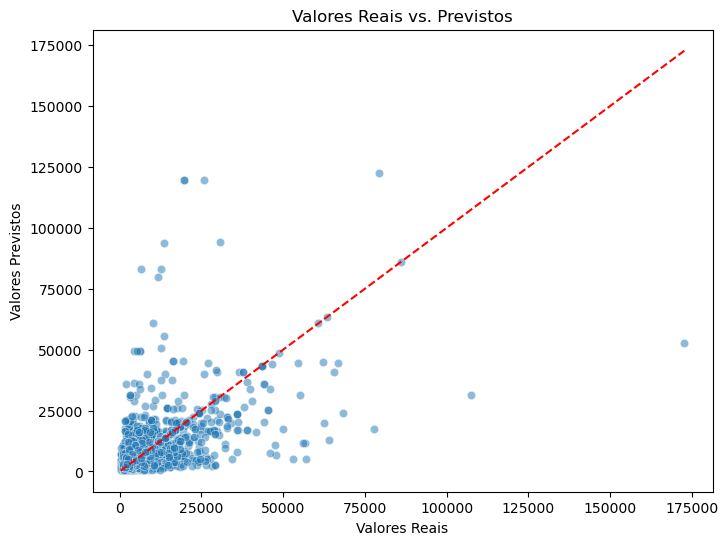

In [31]:
# Comparando valores reais vs. previstos
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')  # Linha ideal
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title("Valores Reais vs. Previstos")
plt.show()

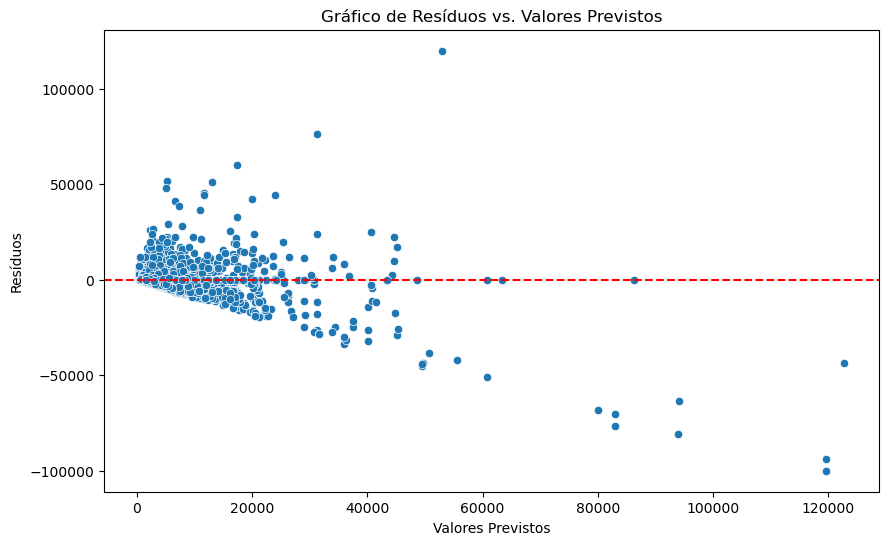

In [32]:
# Calculando os resíduos
residuos = y_test - y_pred  # y_test são os valores reais e y_pred são os valores previstos

# Plotando Resíduos vs. Valores Previstos
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred, y=residuos)
plt.axhline(0, color='r', linestyle='--')  # Linha horizontal em 0 (onde os resíduos são nulos)
plt.title('Gráfico de Resíduos vs. Valores Previstos')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.show()

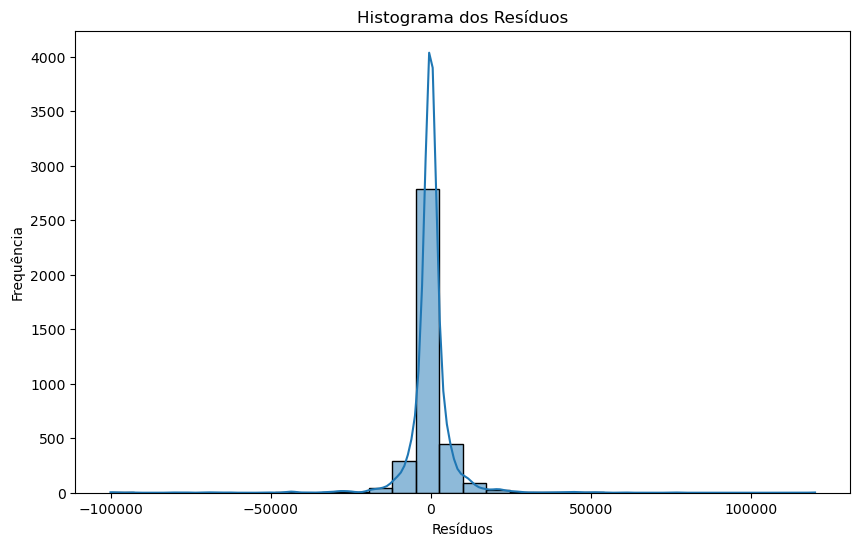

In [33]:
# Plotando o histograma dos resíduos
plt.figure(figsize=(10,6))
sns.histplot(residuos, kde=True, bins=30)
plt.title('Histograma dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

Raiz do Erro Quadrático Médio (RMSE): 6379.85
R²: 0.3659237398357974


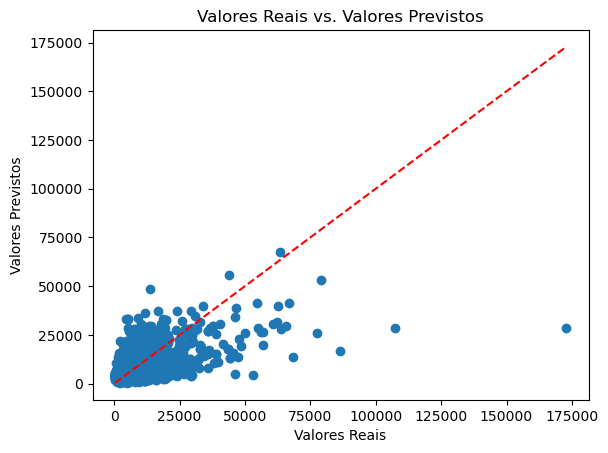

In [34]:
# Transformando os dados para incluir termos polinomiais (grau 2 por exemplo)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Criando o modelo de regressão linear
model = LinearRegression()

# Treinando o modelo com os dados polinomiais
model.fit(X_train_poly, y_train)

# Fazendo previsões
y_pred = model.predict(X_test_poly)

# Avaliando o modelo
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE é a raiz do MSE
r2_poly = r2_score(y_test, y_pred)

# Exibindo os resultados
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse_poly:.2f}")
print(f'R²: {r2_poly}')

# Plotando os valores reais vs. previstos
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Linha 1:1
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Valores Reais vs. Valores Previstos')
plt.show()

### O modelo não esta bom, talvez seja os outliners. Irei diminuir a profundidade da arvore.

In [36]:
# limitando a arvore a 5.
regressor_pruning = DecisionTreeRegressor(max_depth=5, random_state=100)

# Treinando o modelo
regressor_pruning.fit(X_train, y_train)

# Fazendo previsões em X_test
y_pred = regressor_pruning.predict(X_test)

# Avaliando o RMSE
rmse = np.sqrt(mse)
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}")

# Avaliando o R²
r2 = r2_score(y_test, y_pred)
print(f"Coeficiente de Determinação (R²): {r2:.2f}")

Raiz do Erro Quadrático Médio (RMSE): 7415.78
Coeficiente de Determinação (R²): 0.33


### O R² melhorou, mais ainda não é o ideal. Irei identicar outliners e tratalos.

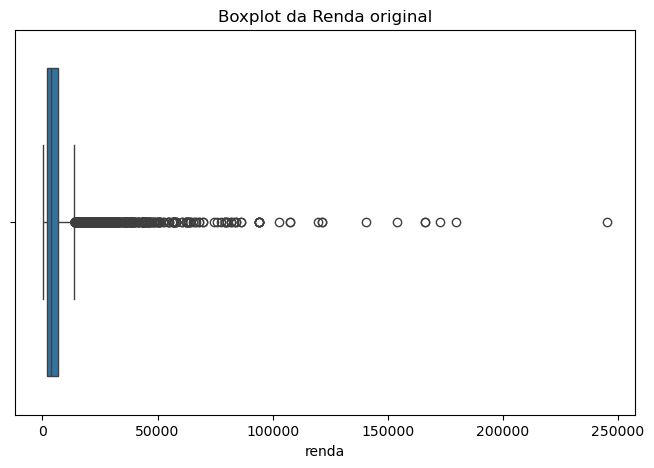

In [38]:
# Identificar outliers com boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=renda_dummie['renda'])
plt.title("Boxplot da Renda original")
plt.show()

Limite inferior: -4970.47
Limite superior: 13936.92


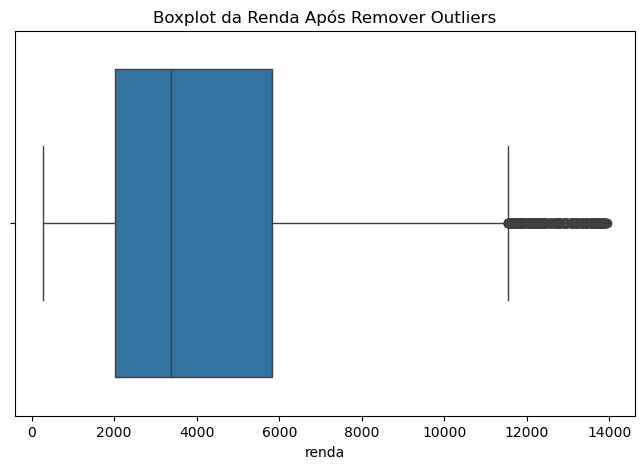

In [39]:
# Identificando outliner com IQR
Q1 = renda_dummie['renda'].quantile(0.25)  # Primeiro quartil (25%)
Q3 = renda_dummie['renda'].quantile(0.75)  # Terceiro quartil (75%)
IQR = Q3 - Q1  # Intervalo Interquartil

# Definindo os limites inferior e superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
print(f"Limite inferior: {limite_inferior:.2f}")
print(f"Limite superior: {limite_superior:.2f}")

# Removendo valores fora do limite entre os quartis
renda_dummie_IQR = renda_dummie[(renda_dummie['renda'] >= limite_inferior) & (renda_dummie['renda'] <= limite_superior)]

plt.figure(figsize=(8, 5))
sns.boxplot(x=renda_dummie_IQR['renda'])
plt.title("Boxplot da Renda Após Remover Outliers")
plt.show()

In [40]:
# testando o modelo novamente:

# Escolhendo o modelo
regressor_DTR_IQR = DecisionTreeRegressor(random_state=100)

# Treinando o modelo
regressor_DTR_IQR.fit(X_train, y_train)

# Fazendo previsões
y_pred = regressor_DTR_IQR.predict(X_test)

# Calculando o R²
r2 = r2_score(y_test, y_pred)
print(f"Coeficiente de Determinação (R²) após remoção de outliers: {r2:.2f}")



Coeficiente de Determinação (R²) após remoção de outliers: 0.14


### O R² de 0.14 após a remoção dos outliers indica que o modelo ainda está tendo dificuldades para explicar a variação na variável renda. Já o R² de 0.33 antes de remover os outliers foi um pouco melhor, o que sugere que os outliers poderiam estar ajudando de alguma forma no modelo, talvez representando valores válidos ou influenciando a árvore de decisão.

In [42]:
# Testando outro tipo de arvore
regressor_forest = RandomForestRegressor(random_state=100)
regressor_forest.fit(X_train, y_train)
y_pred_2 = regressor_forest.predict(X_test)
r2_2 = r2_score(y_test, y_pred_2)
print(f"R² com Random Forest: {r2_2:.2f}")

# Calculando o RMSE
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred_2))  # RMSE é a raiz do MSE
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse_2:.2f}")

# Calculando o MAE
mae_2 = mean_absolute_error(y_test, y_pred_2)
print(f"Erro absoluto médio (MAE): {mae_2:.2f}")

# Calculando o MSE
mse_2 = mean_squared_error(y_test, y_pred_2)
print(f"Erro Quadrático Médio (MSE): {mse_2:.2f}")

R² com Random Forest: 0.41
Raiz do Erro Quadrático Médio (RMSE): 6177.13
Erro absoluto médio (MAE): 3015.47
Erro Quadrático Médio (MSE): 38156880.48


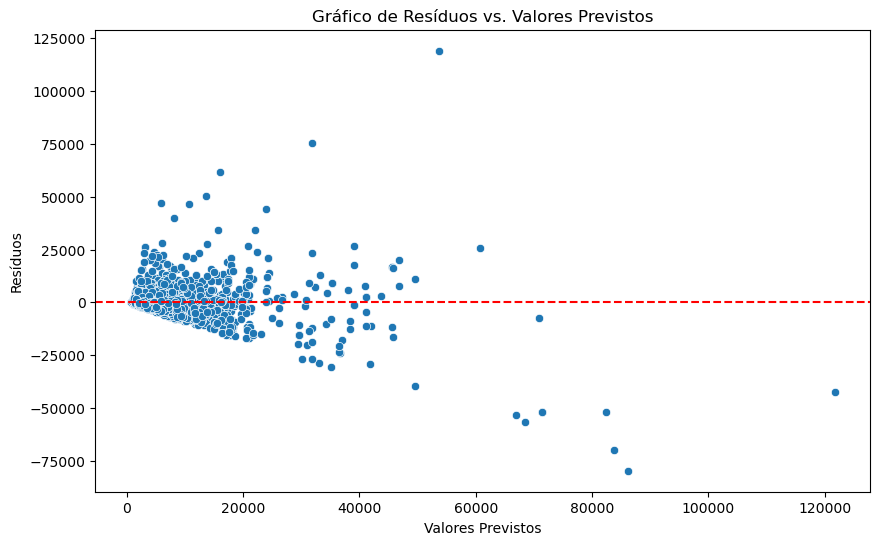

In [43]:
# Calculando os resíduos
residuos_2 = y_test - y_pred_2  # y_test são os valores reais e y_pred são os valores previstos

# Plotando Resíduos vs. Valores Previstos
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred_2, y=residuos_2)
plt.axhline(0, color='r', linestyle='--')  # Linha horizontal em 0 (onde os resíduos são nulos)
plt.title('Gráfico de Resíduos vs. Valores Previstos')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.show()

### O Teste com outro tipo de arvore melhorou o R², vamos utilizar esse modelo para implementação. 

## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.

In [64]:
import pickle

# Salvando o modelo
with open("regressor_forest.pkl", "wb") as file:
    pickle.dump(regressor_forest, file)

In [66]:
with open("regressor_forest.pkl", "rb") as file:
    modelo = pickle.load(file)

print(type(modelo))

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
